In [2]:
import numpy as np
from math import*
#import matplotlib.pyplot 
import matplotlib.pyplot as plt
import random
import scipy
import scipy.stats
#from scipy.optimize import NonlinearConstraint
plt.rcParams["figure.figsize"] = (8,8)

In [3]:
class CauchyBandit :
    def __init__(self, loc, scale, seed = None):
        ''' Entrées:
                - loc: un array décrivant les paramètres de localisations des lois de Cauchy décrivant les actions
                - scale: un array décrivant les paramètres d'échelle des lois de Cauchy décrivant les actions
                - seed (optionnel): un seed. 
        '''

        np.random.seed(seed=seed)
        
        self.loc = loc
        
        self.scale= scale
        
        self.ps_regrets = []

        self.locstar = max(self.loc)
        
        self.kstar = np.argmax(loc)
        
        self.gaps = self.locstar - loc

        
    def get_K(self):
        ''' Return the number of actions . '''

        K = len(self.loc)
        
        return K
        
    def play(self,action):
        ''' Accept a parameter 0 <= k < K, logs the instant pseudo - regret ,
        and return the realization of a Bernoulli random variable with P(X =1)
        being the mean of the given action . '''

        #méthode de conténation append
        self.ps_regrets.append(self.gaps[action])
        
        reward = scipy.stats.cauchy.rvs(self.loc[action], self.scale[action],size=1)
        
        return reward

    def get_cumulative_regret(self):
        ''' Return an array of the cumulative sum of pseudo - regret per round . '''
        return np.cumsum(self.ps_regrets)

In [4]:
def median_estimator(X):
    return np.median(X)

In [23]:
def mean_estimator(X):
    return np.mean(X)

In [13]:
def truncated_mean_estimator(X, tmean):
    return scipy.stats.trim_mean(X, tmean)

source : https://stats.stackexchange.com/questions/174117/maximum-likelihood-estimator-of-location-parameter-of-cauchy-distribution/174130

In [14]:
def maximum_likelihood_estimator(X, tolerance=0.001):
    LOG_LIKELIHOOD_DERIVATIVE = lambda x, theta: 2 * sum((x - theta) / (1 + (x - theta)**2))
    theta_estimation = np.median(X)
    
    first_deriv = LOG_LIKELIHOOD_DERIVATIVE(X, theta_estimation)
    
    while abs(first_deriv) > tolerance:
        second_deriv = 2 * sum(((X - theta_estimation)**2 - 1) / (1 + (X - theta_estimation)**2)**2)
        theta_estimation = theta_estimation - first_deriv / second_deriv
        first_deriv = LOG_LIKELIHOOD_DERIVATIVE(X, theta_estimation)
    
    return theta_estimation

In [15]:
maximum_likelihood_estimator(scipy.stats.cauchy.rvs(1, 5, size=50))

-1.5284010035501558

source : https://link-springer-com.acces.bibl.ulaval.ca/article/10.1007/s00180-009-0163-y

In [16]:
def L_estimator(X):
    N = len(X)
    estimation = 0
    x_sorted = np.sort(X)

    for i in range(N):
        u = i / (N+1)
        estimation += (np.sin(4* np.pi * (u - 0.5)) / tan(np.pi * (u - 0.5))) * x_sorted[i]
    
    return estimation / N

In [17]:
def etc(bandit , T, m,  estimator, discret=False):
    '''T: L'horizon
       m: Le nombre de tirage de chacune des actions dans le tour exploratoire
       discret: Pour faire un bris d'égalité ou non (nécessaire dans le cas de distributions discrètes)
       estimator: une lambda calculant l'estimation empirique '''
     
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    
    # Phase d'exploration (m tours sur chaque action)
    
    estimateurs = []
    for k in range(bandit.get_K()):
        m_estimateurs = []
        for i in range(m):
            m_estimateurs.append(bandit.play(k))
        estimateurs.append(estimator(m_estimateurs))
    
    '''R = []
   
    for k in range(K):
        R.append([])
    
    estimateurs = [] 
    
    for k in range(K):
        for j in range(m):
            R[k].append(bandit.play(k))  
            
        estimateurs.append(estimator(R, k))
        '''

    # Calcul de l'action optimale

    ##Si la loi des bras est discrète, on doit gérer le cas où il peut y avoir bris d'égalité. 
    if(discret):
        kstar_est = np.where(estimateurs == max(estimateurs))[0]

        if (len(kstar_est) > 1):
            kstar_est = np.random.choice(kstar_est,1)[0]
    else:
        kstar_est = np.argmax(estimateurs)
            
    # Phase d'exploitation

    for t in range(m*K,T):
        r_t=bandit.play(kstar_est)

    return kstar_est


On compare maintenant la méthode etc(median=True) avec la méthode etc(median=True) dans une situation avec un bandit à deux bras de Cauchy de positions 5 et 6. 

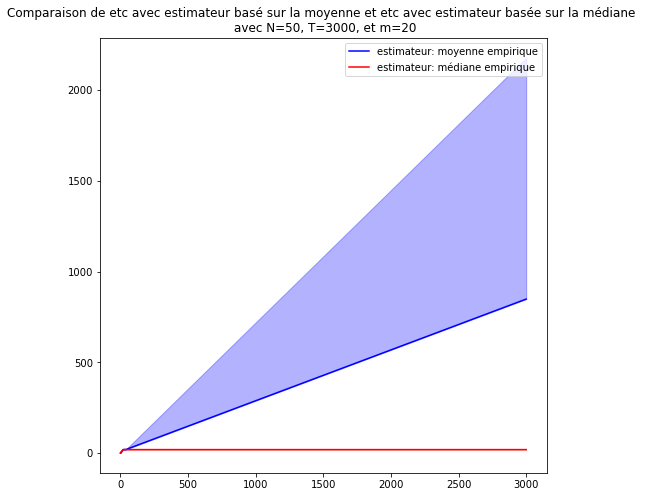

In [28]:
TRIM_MEAN = 0.25
N,T = 50, 3000

m=20

loc=np.array([5,6])
scale=np.array([1,1])


cum_regrets_etc_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    etc(banditest, T=T, m=m, estimator=mean_estimator, discret=False)
    cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue', label='estimateur: moyenne empirique') #affichage du graphique
plt.fill_between(range(T), cum_regrets_etc_moyenne_moy, cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', alpha=0.3)



cum_regrets_etc_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    etc(banditest, T=T, m=m, estimator=median_estimator, discret=False)
    cum_regrets_etc_median.append(banditest.get_cumulative_regret())

cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label='estimateur: médiane empirique') #affichage du graphique
plt.fill_between(range(T), cum_regrets_etc_median_moy, cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', alpha=0.3)
'''

cum_regrets_etc_tmean = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=None)
    etc(banditest, T=T, m=m, estimator=lambda X: truncated_mean_estimator(X, TRIM_MEAN) , discret=False)
    cum_regrets_etc_tmean.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_tmean_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_tmean)
cum_regrets_etc_tmean_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_tmean)

plt.plot(range(T),cum_regrets_etc_tmean_moy, color='green', label='estimateur: moyenne tronquée empirique') #affichage du graphique
# plt.fill_between(range(T), cum_regrets_etc_tmean_moy, cum_regrets_etc_tmean_moy + cum_regrets_etc_tmean_sd, color='green', alpha=0.3)


cum_regrets_etc_l_estim = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=None)
    etc(banditest, T=T, m=m, estimator=L_estimator, discret=False)
    cum_regrets_etc_l_estim.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_l_estim_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_l_estim)
cum_regrets_etc_l_estim_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_l_estim)

plt.plot(range(T),cum_regrets_etc_l_estim_moy, color='purple', label='estimateur: L-estimator de paramètre de location') #affichage du graphique
# plt.fill_between(range(T), cum_regrets_etc_l_estim_moy, cum_regrets_etc_l_estim_moy + cum_regrets_etc_l_estim_sd, color='purple', alpha=0.3)


cum_regrets_etc_max_likelihood = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=None)
    etc(banditest, T=T, m=m, estimator=maximum_likelihood_estimator, discret=False)
    cum_regrets_etc_max_likelihood.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_max_likelihood_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_max_likelihood)
cum_regrets_etc_max_likelihood_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_max_likelihood)

print(range(T))
plt.plot(range(T),cum_regrets_etc_max_likelihood_moy, color='yellow', label='estimateur: maximum likelihood') #affichage du graphique
# plt.fill_between(range(T), cum_regrets_etc_max_likelihood_moy, cum_regrets_etc_max_likelihood_moy + cum_regrets_etc_max_likelihood_sd, color='yellow', alpha=0.3)
'''

plt.title('Comparaison de etc avec estimateur basé sur la moyenne et etc avec estimateur basée sur la médiane \n avec N={}, T={}, et m={}'.format(N,T,m))
plt.legend()

#print(cum_regrets)
#print(cum_regrets_moy)
#print(cum_regrets_sd)


L'expérience montre que la méthode classique se fait déjouer par les queues lourdes de la distribution de Cauchy, alors que la méthode utilisant un estimateur de localisation plus robuste (ici la médiane) a de meilleurs performances.

On mène ci-dessous une étude plus complète avec des paramètres de localisations choisient aléatoirement dans l'intervalle (0,1).

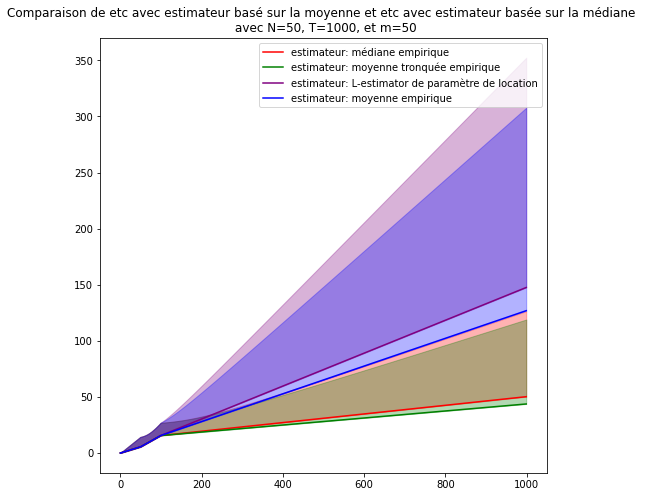

In [26]:
N,T = 50, 1000

m=50

loc=np.random.rand(50,2)

scale=np.array([1,1])

'''cum_regrets_etc_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=None)
    etc(banditest, T=T, m=m, estimator=median_estimator, discret=False)
    cum_regrets_etc_median.append(banditest.get_cumulative_regret())

cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label='estimateur: mediane') #affichage du graphique
plt.fill_between(range(T), cum_regrets_etc_median_moy, cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', alpha=0.3)
'''

cum_regrets_etc_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=None)
    etc(banditest, T=T, m=m, estimator=median_estimator, discret=False)
    cum_regrets_etc_median.append(banditest.get_cumulative_regret())

cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label='estimateur: médiane empirique') #affichage du graphique
plt.fill_between(range(T), cum_regrets_etc_median_moy, cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', alpha=0.3)


cum_regrets_etc_tmean = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=None)
    etc(banditest, T=T, m=m, estimator=lambda X: truncated_mean_estimator(X, TRIM_MEAN) , discret=False)
    cum_regrets_etc_tmean.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_tmean_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_tmean)
cum_regrets_etc_tmean_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_tmean)

plt.plot(range(T),cum_regrets_etc_tmean_moy, color='green', label='estimateur: moyenne tronquée empirique') #affichage du graphique
plt.fill_between(range(T), cum_regrets_etc_tmean_moy, cum_regrets_etc_tmean_moy + cum_regrets_etc_tmean_sd, color='green', alpha=0.3)


cum_regrets_etc_l_estim = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=None)
    etc(banditest, T=T, m=m, estimator=L_estimator, discret=False)
    cum_regrets_etc_l_estim.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_l_estim_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_l_estim)
cum_regrets_etc_l_estim_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_l_estim)

plt.plot(range(T),cum_regrets_etc_l_estim_moy, color='purple', label='estimateur: L-estimator de paramètre de location') #affichage du graphique
plt.fill_between(range(T), cum_regrets_etc_l_estim_moy, cum_regrets_etc_l_estim_moy + cum_regrets_etc_l_estim_sd, color='purple', alpha=0.3)


cum_regrets_etc_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=None)
    etc(banditest, T=T, m=m, estimator=mean_estimator, discret=False)
    cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue', label='estimateur: moyenne empirique') #affichage du graphique
plt.fill_between(range(T), cum_regrets_etc_moyenne_moy, cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', alpha=0.3)


plt.title('Comparaison de etc avec estimateur basé sur la moyenne et etc avec estimateur basée sur la médiane \n avec N={}, T={}, et m={}'.format(N,T,m))
plt.legend()

#print(cum_regrets)
#print(cum_regrets_moy)
#print(cum_regrets_sd)


Ci-dessous, on fait une étude plus exhaustive en faisant varier m

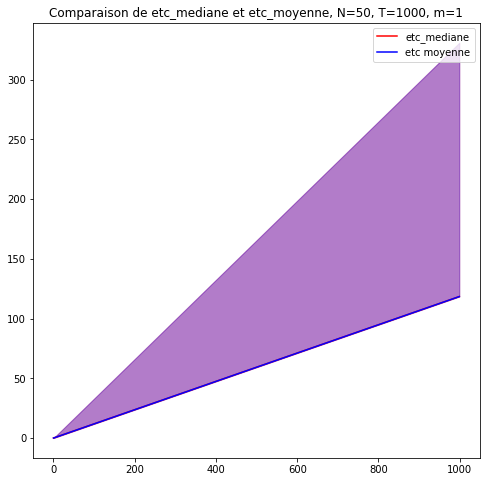

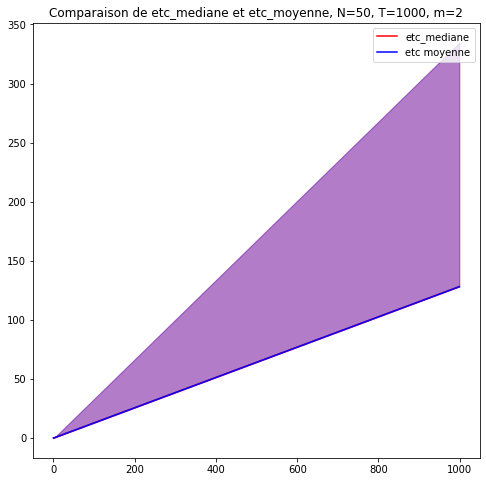

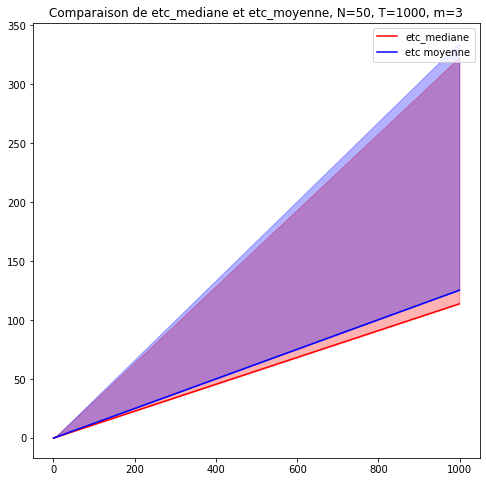

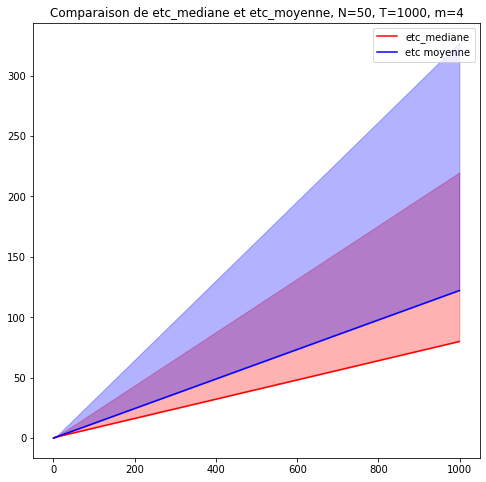

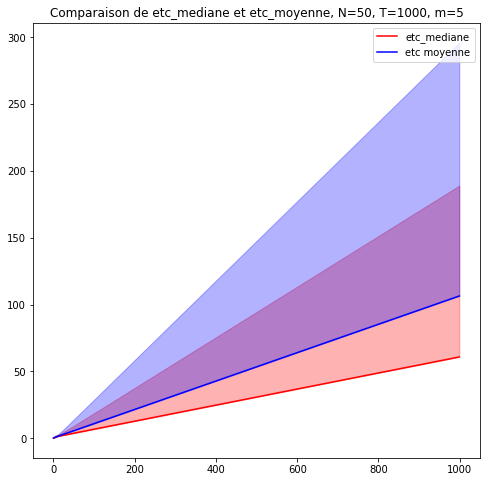

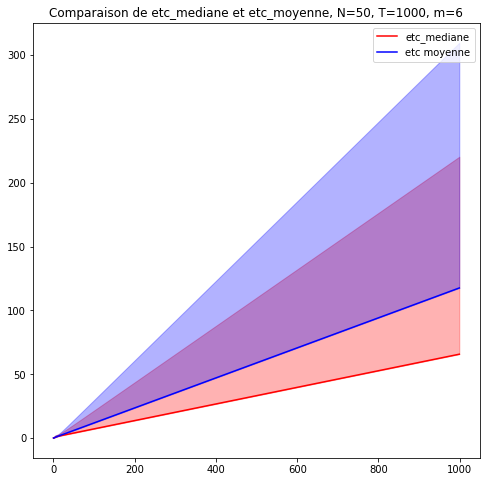

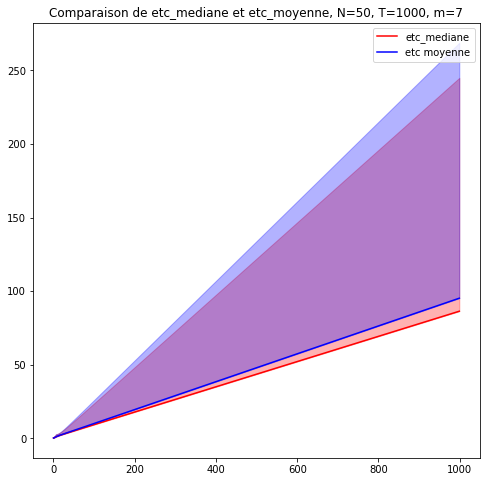

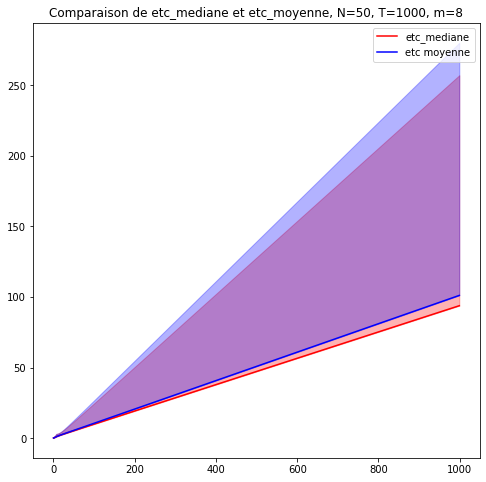

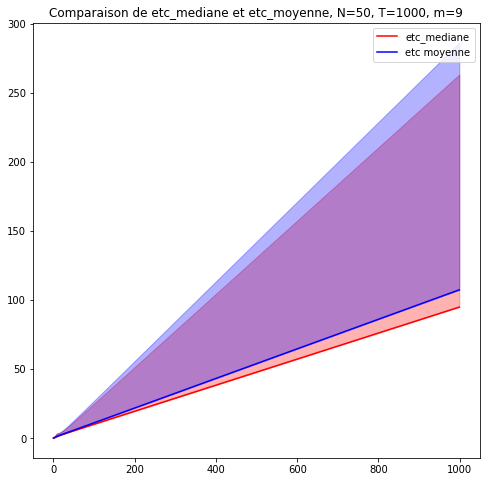

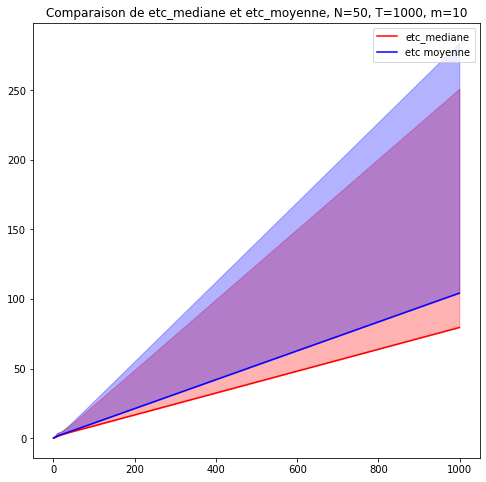

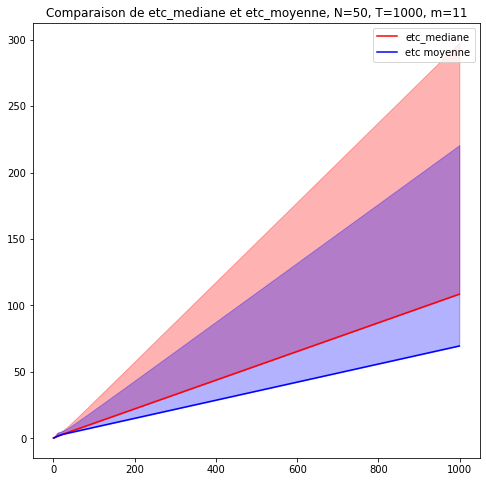

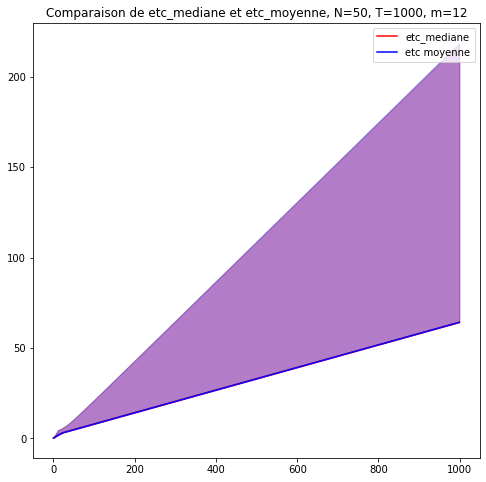

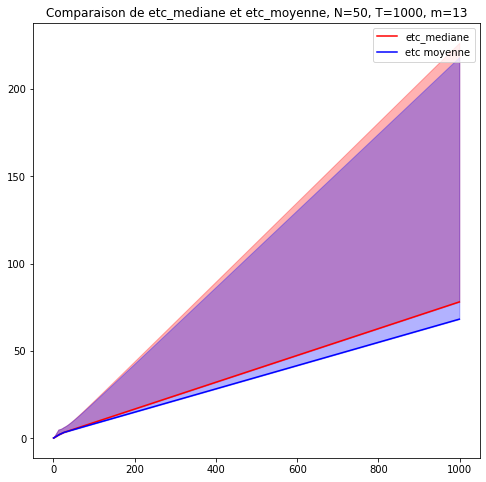

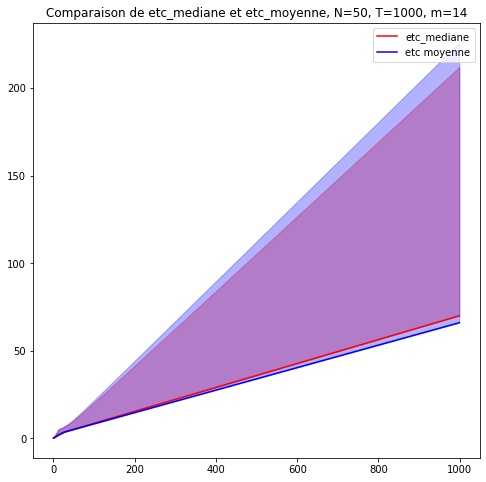

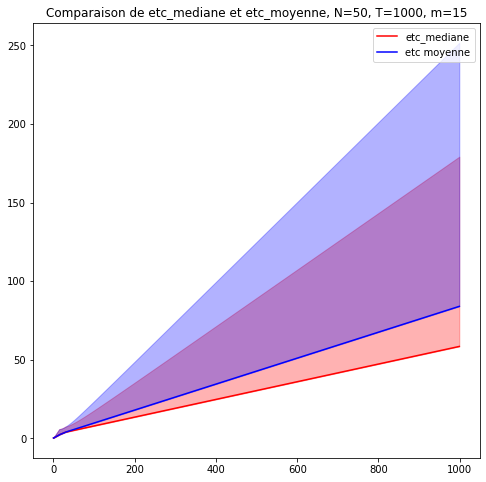

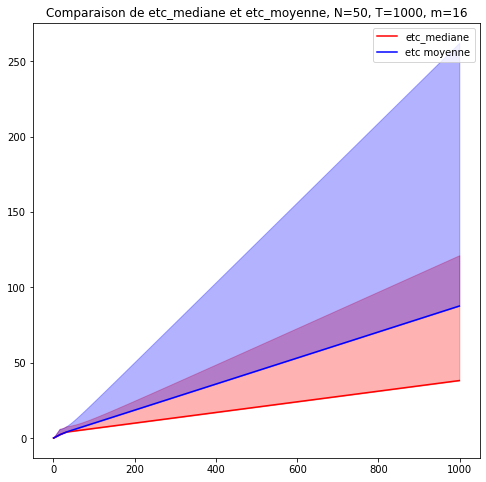

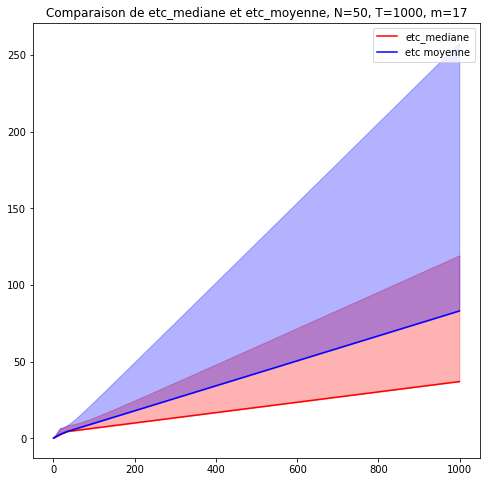

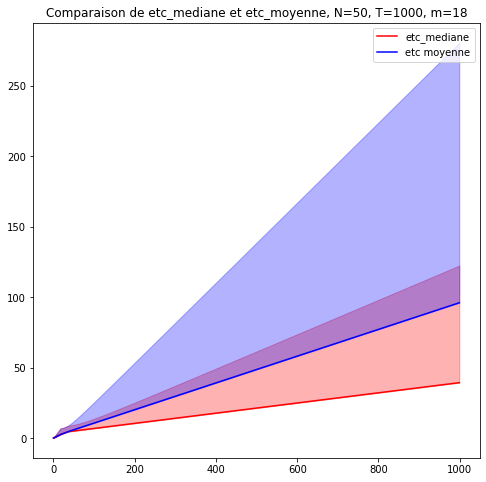

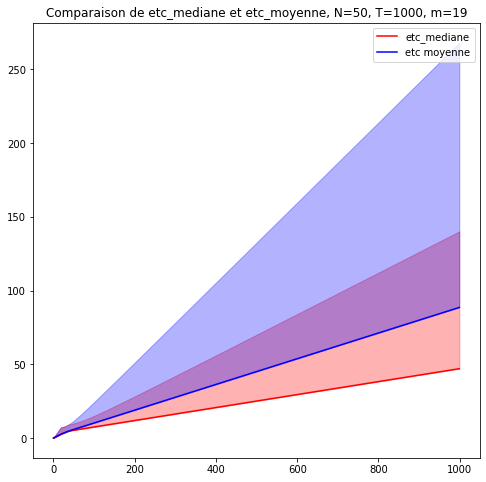

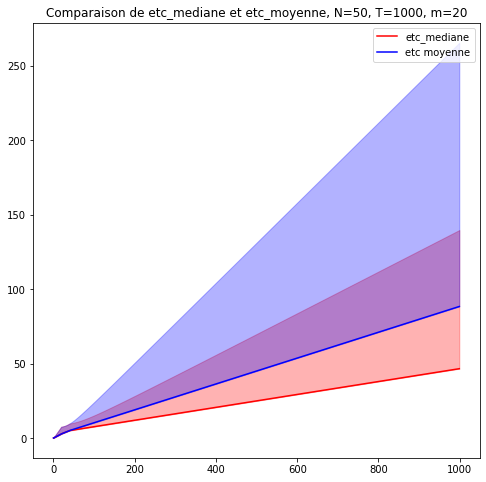

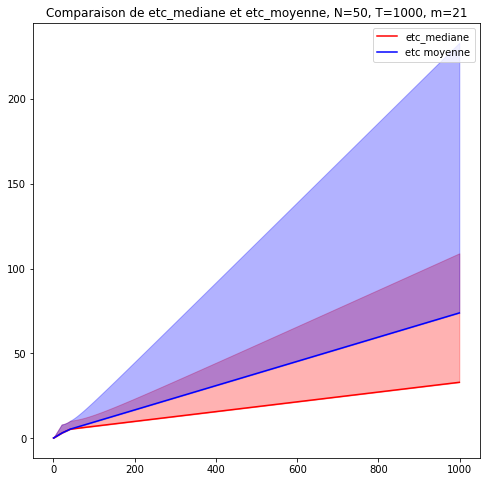

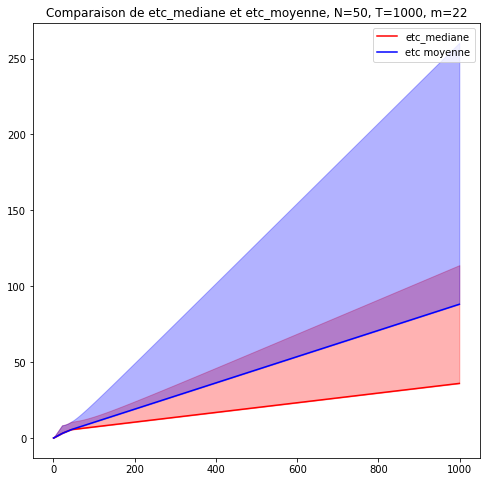

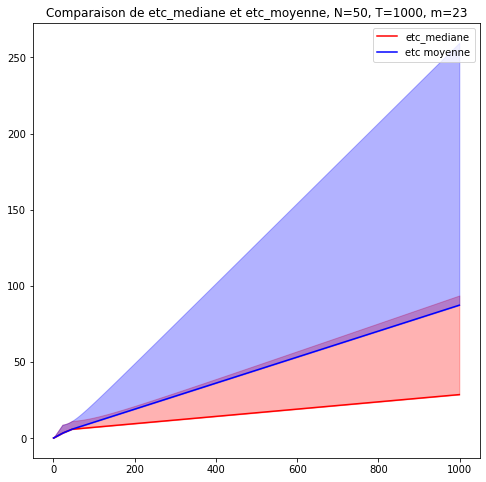

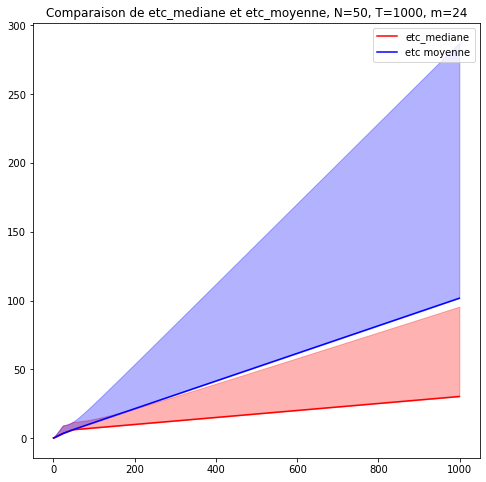

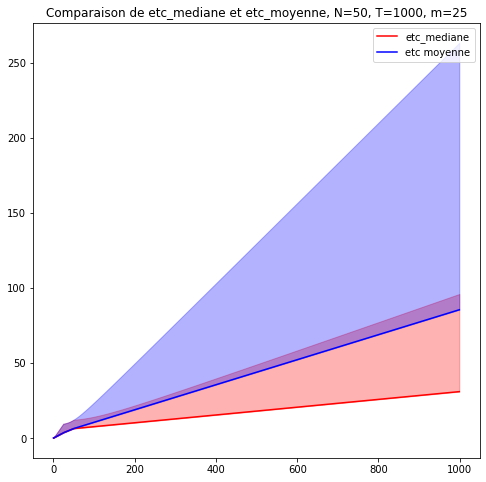

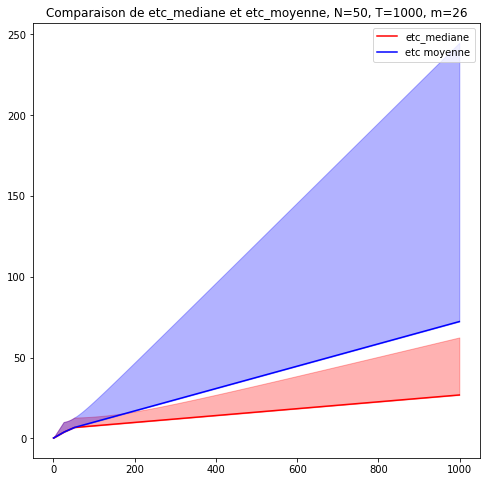

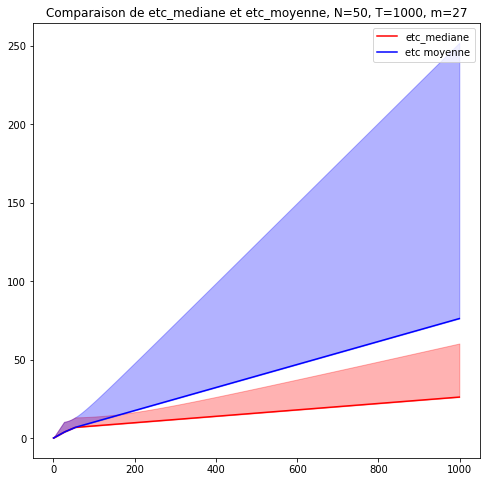

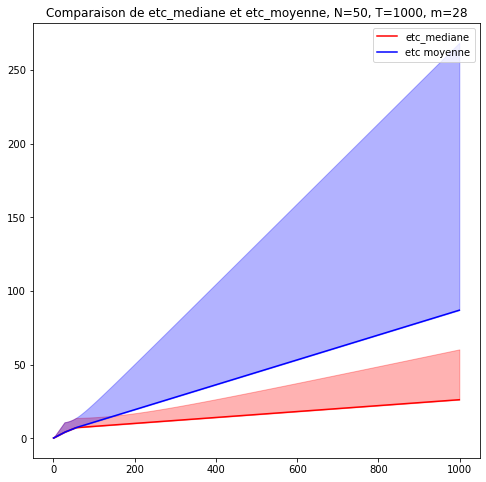

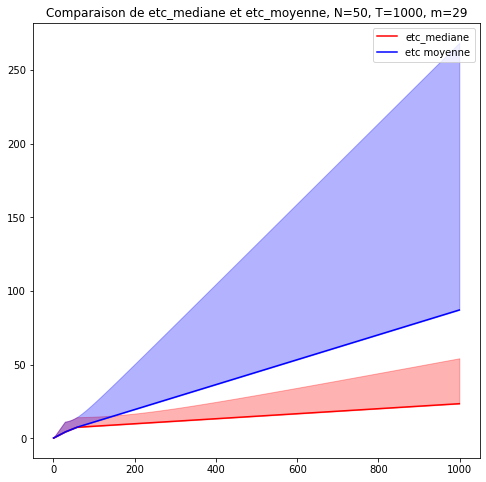

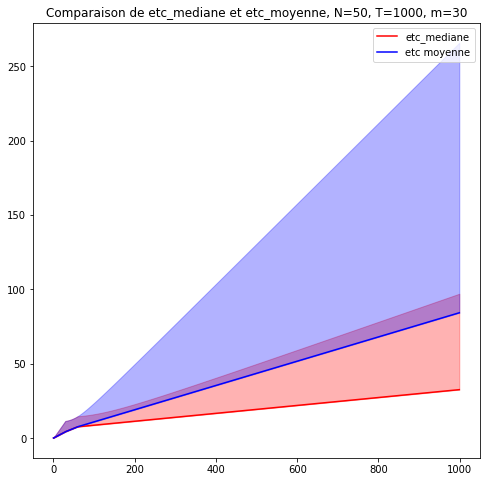

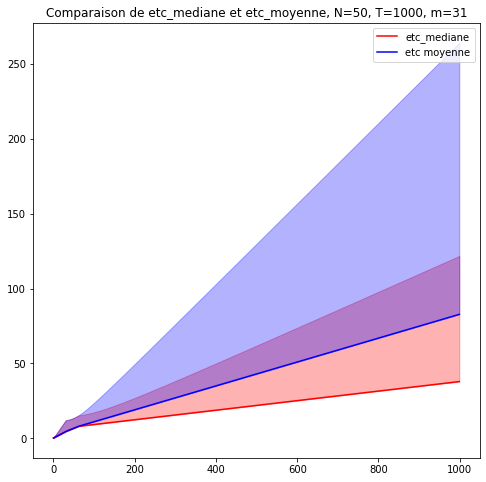

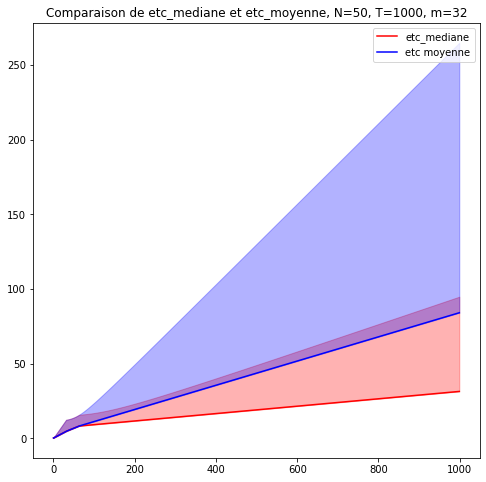

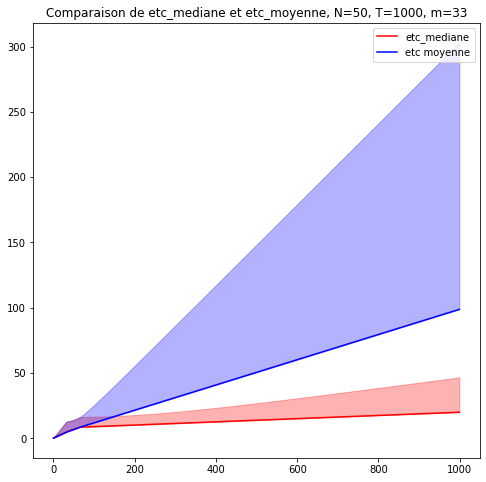

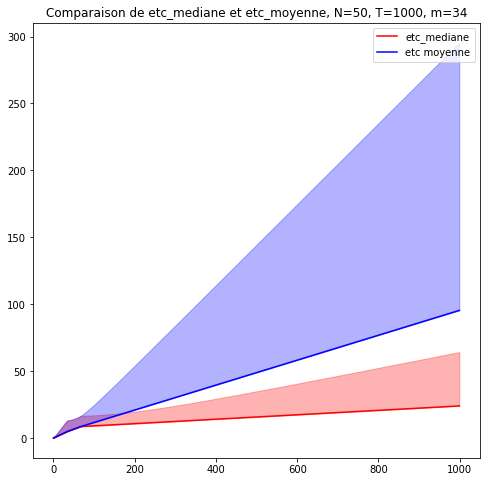

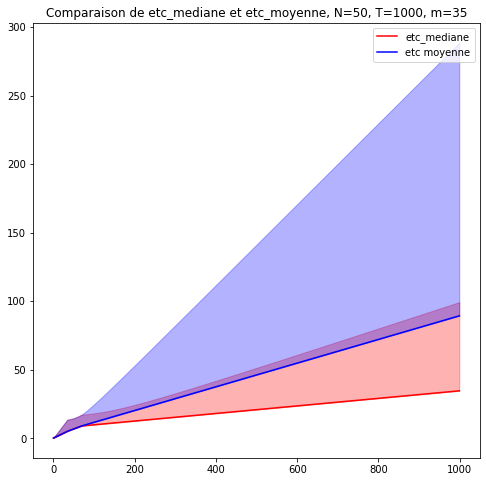

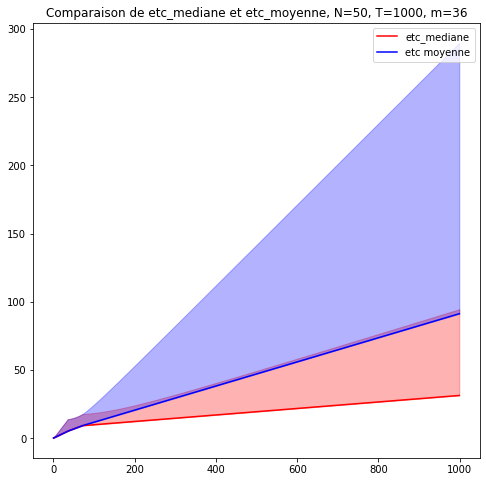

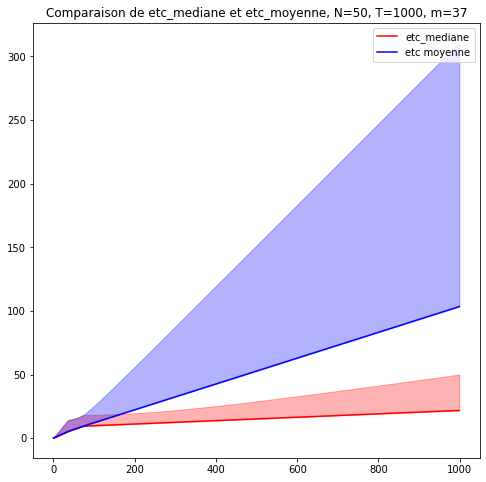

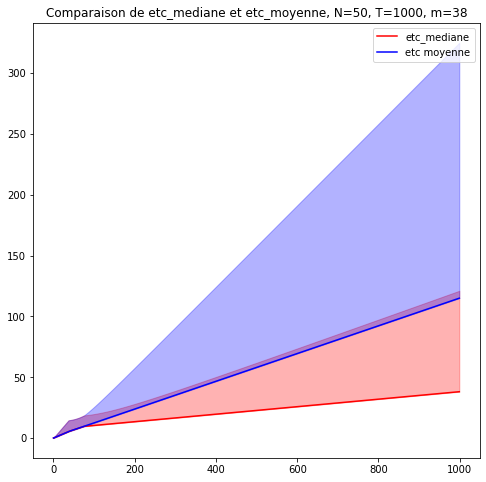

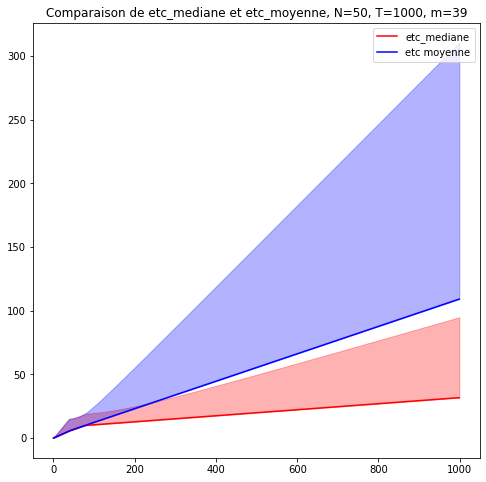

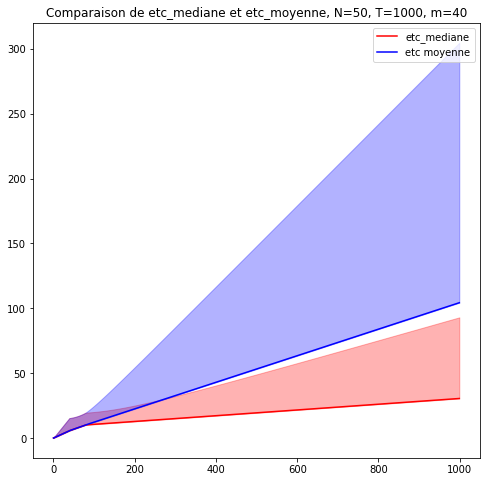

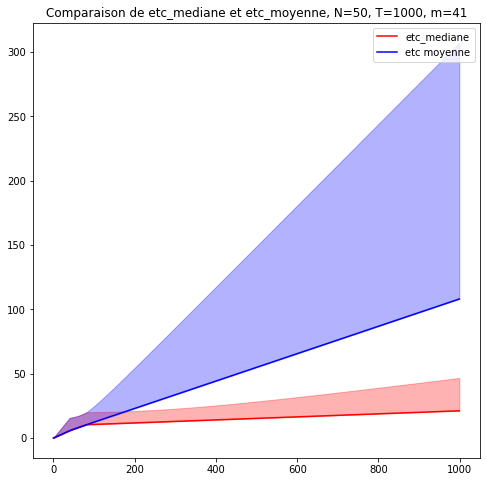

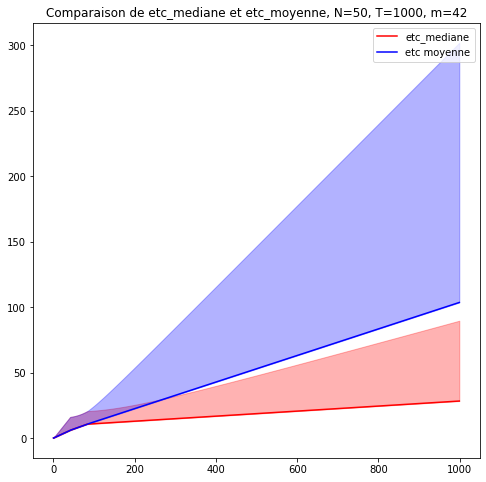

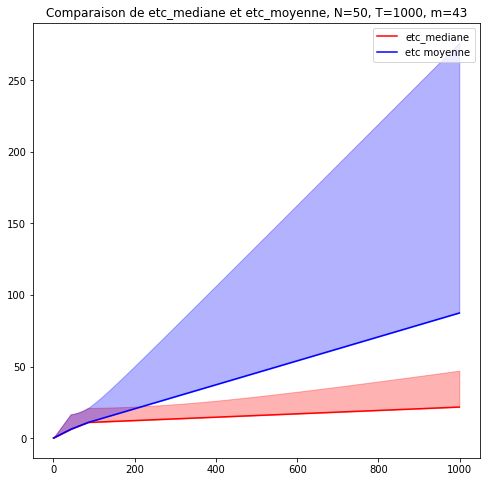

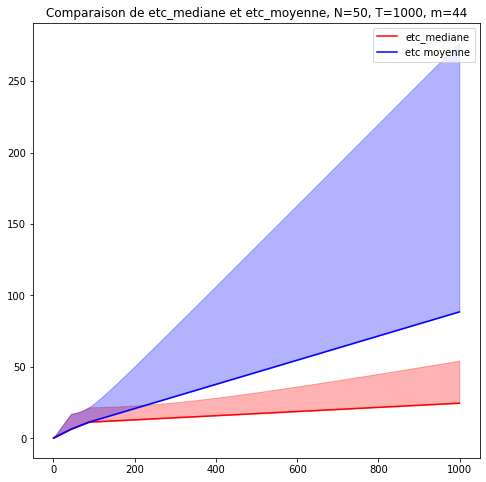

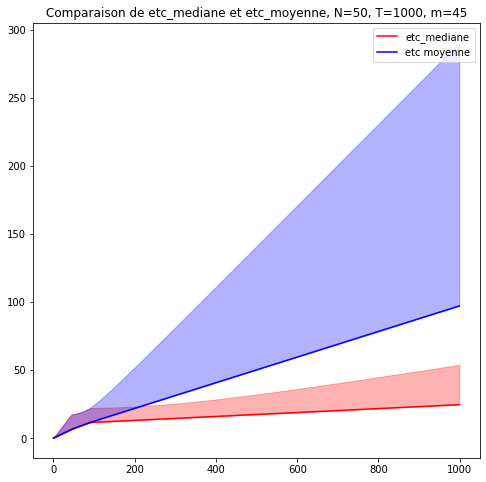

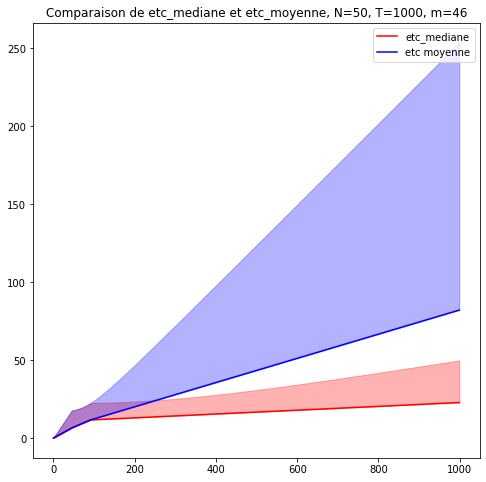

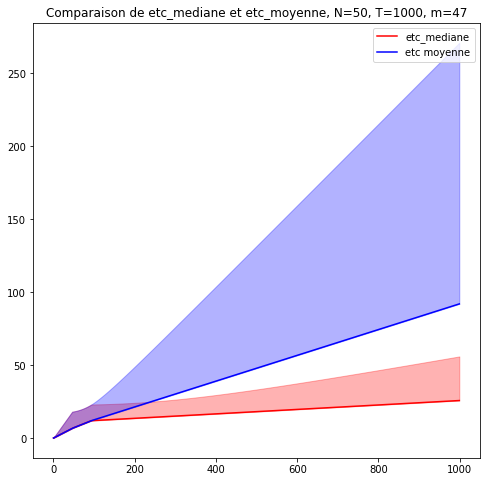

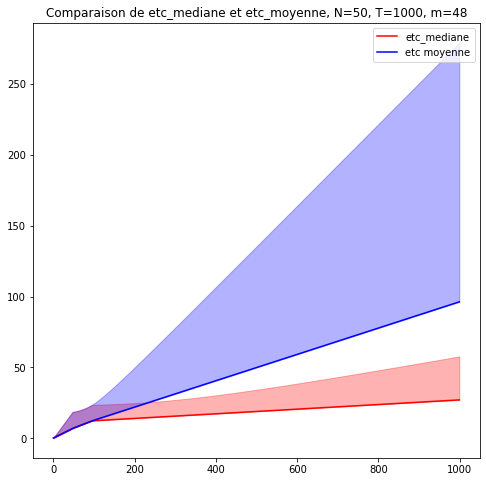

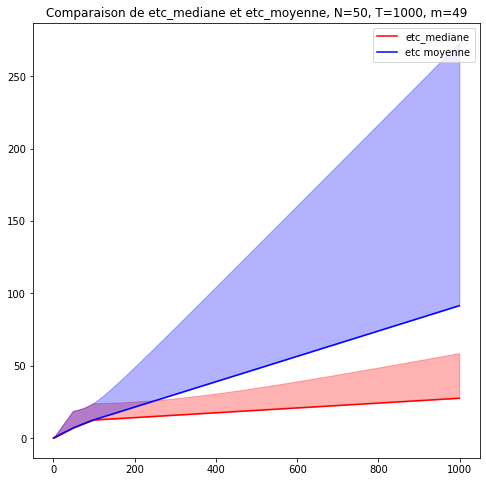

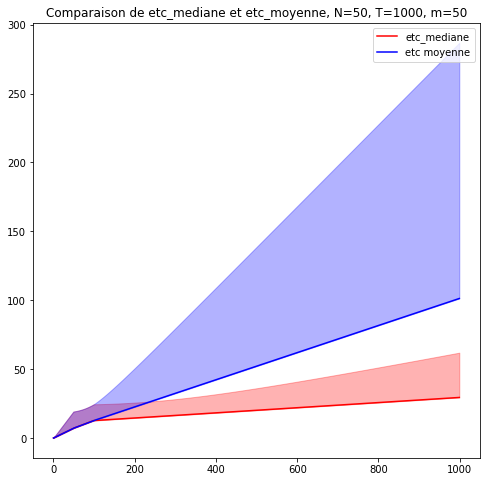

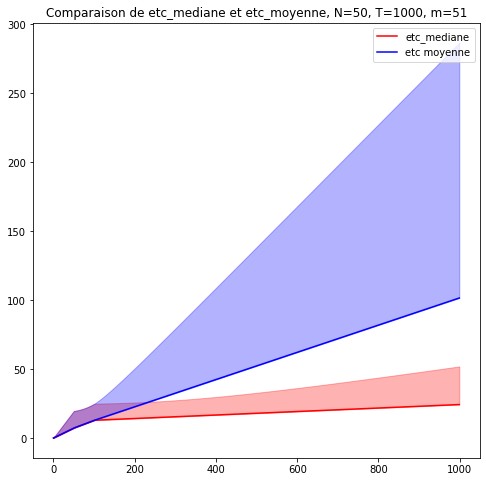

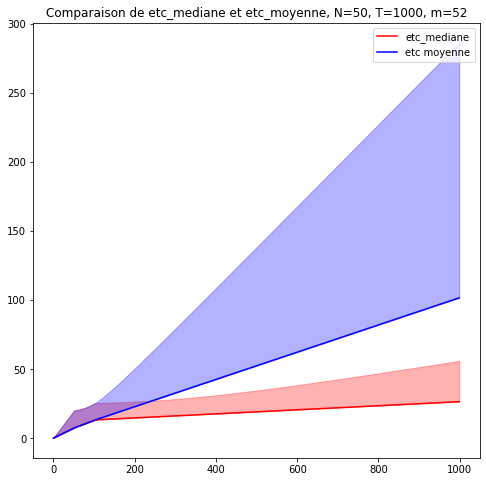

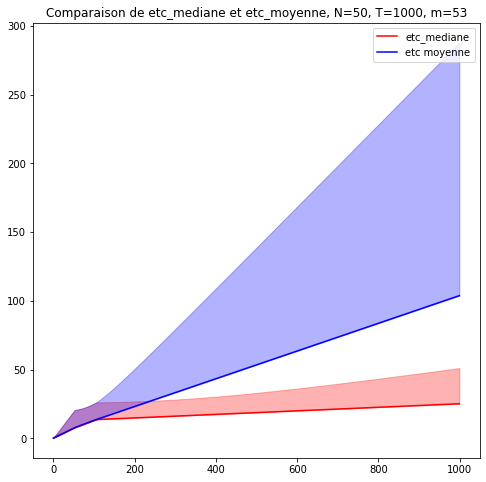

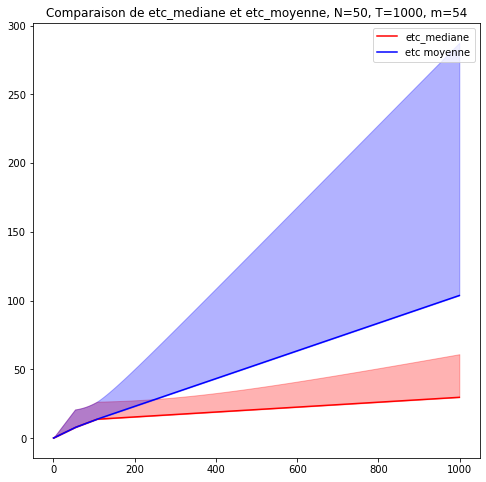

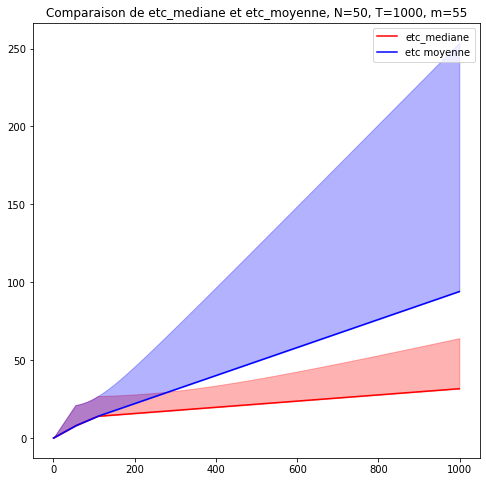

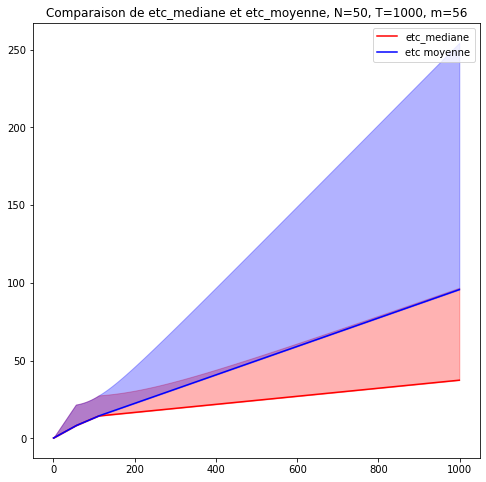

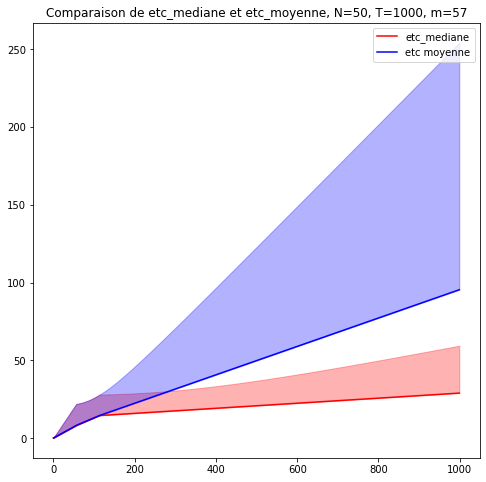

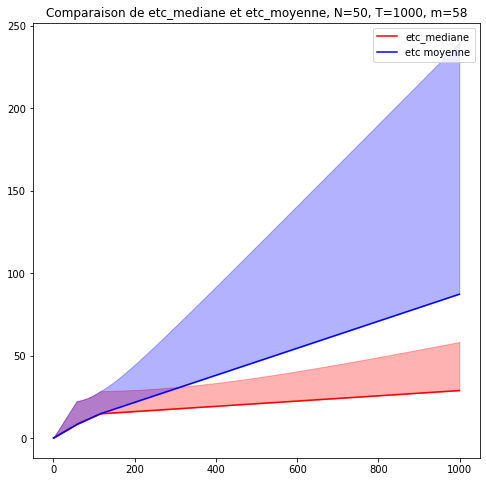

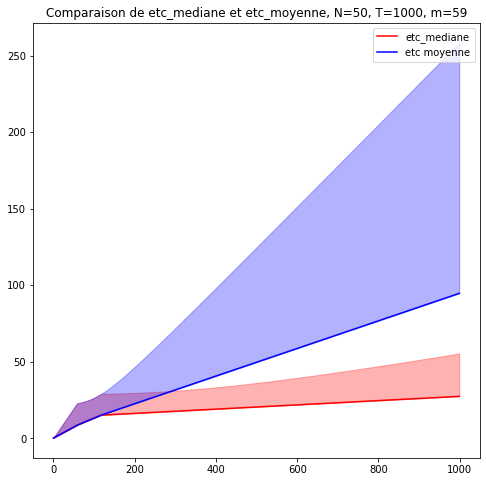

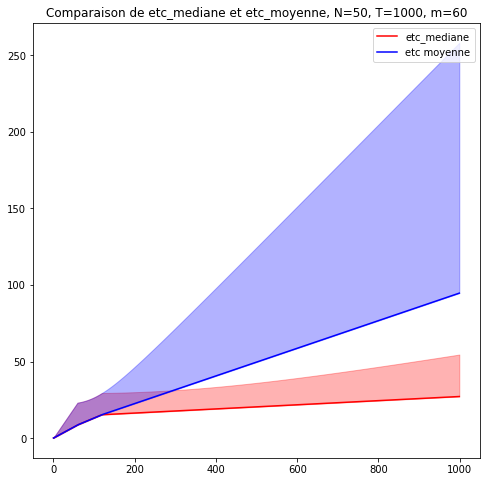

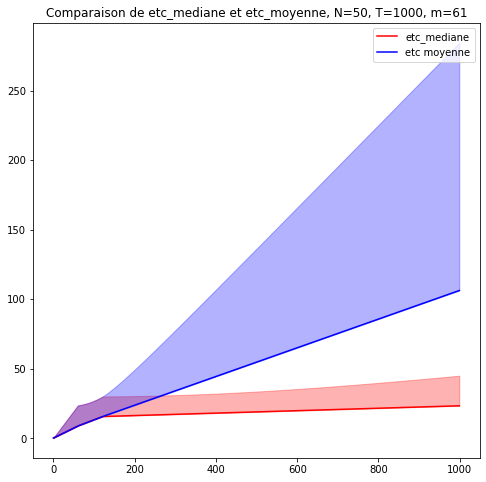

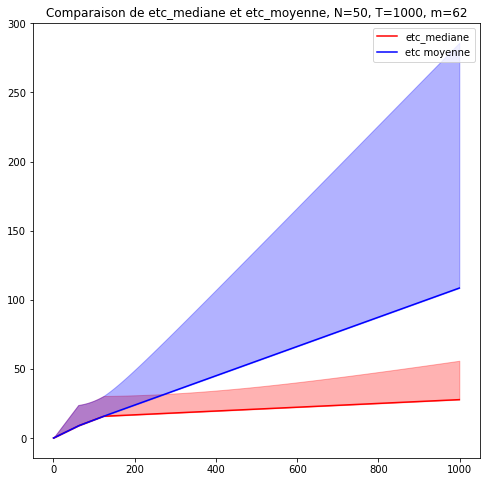

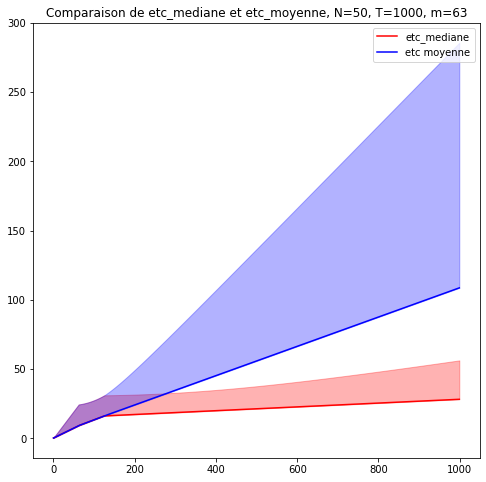

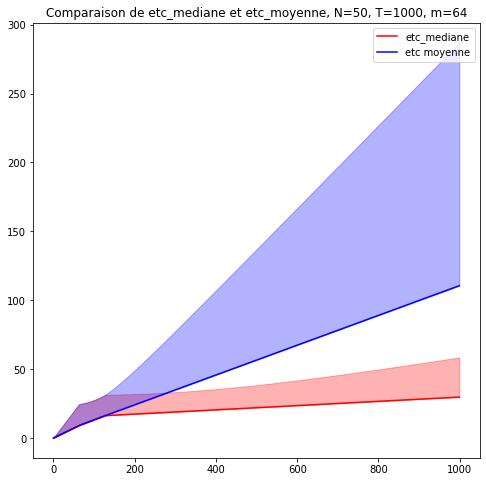

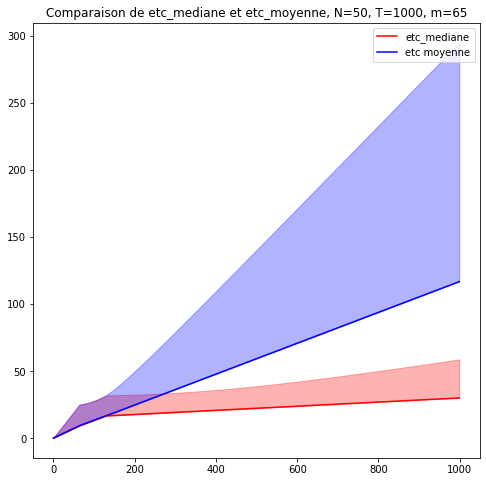

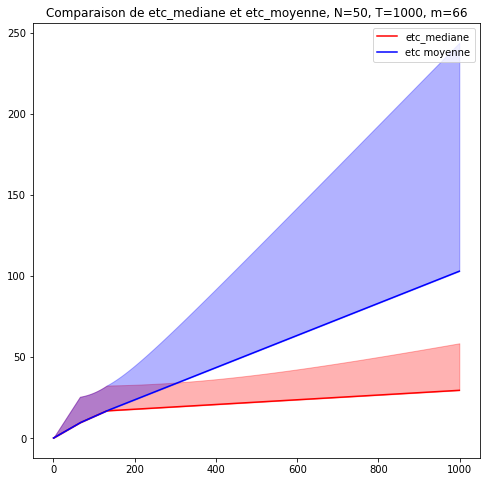

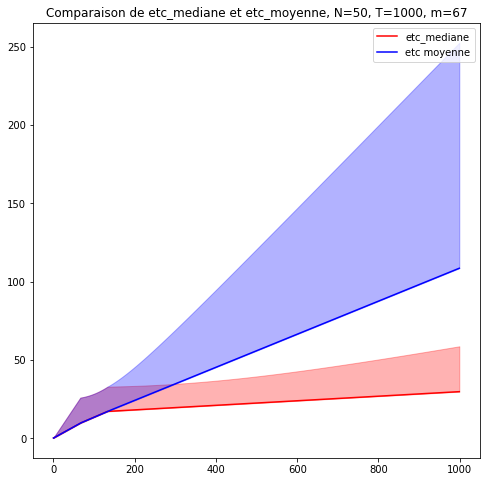

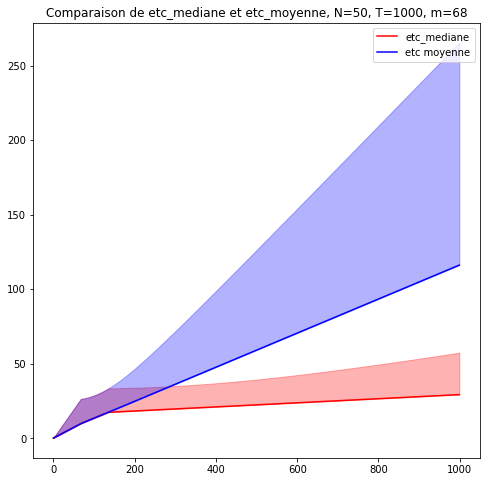

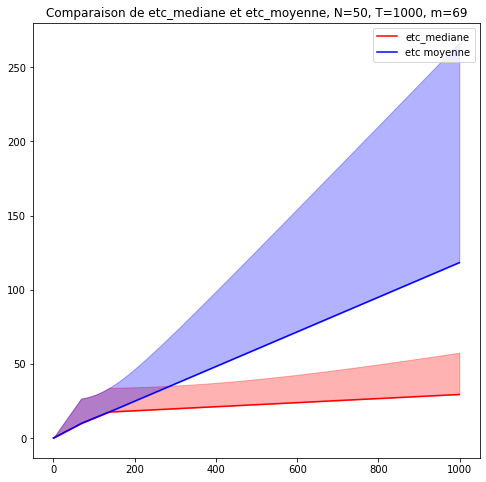

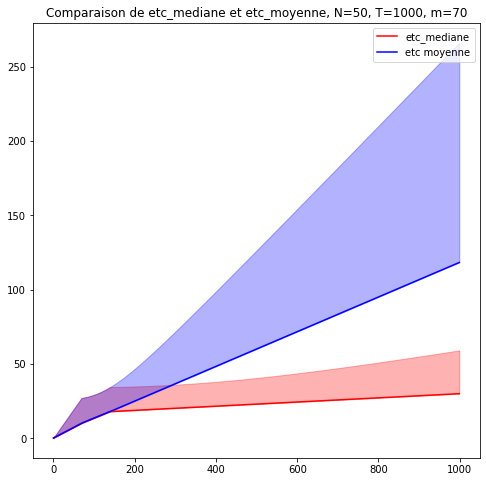

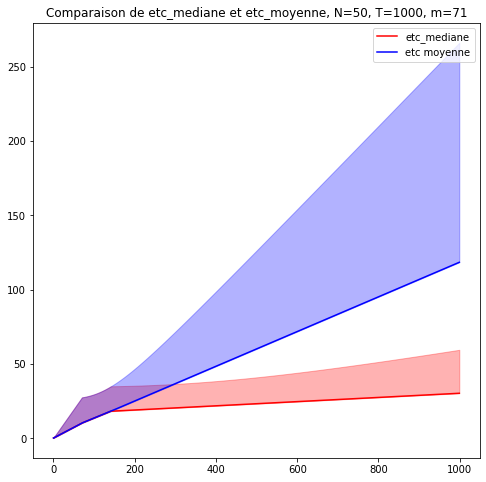

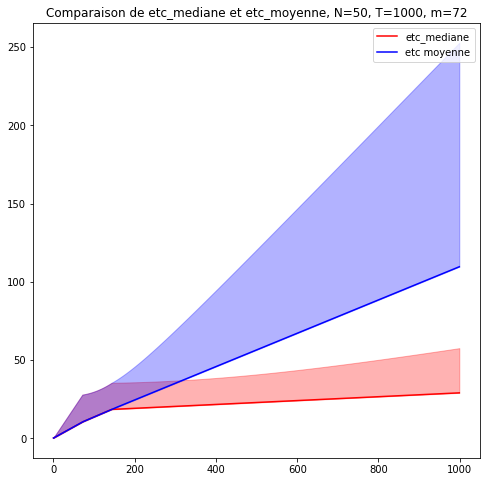

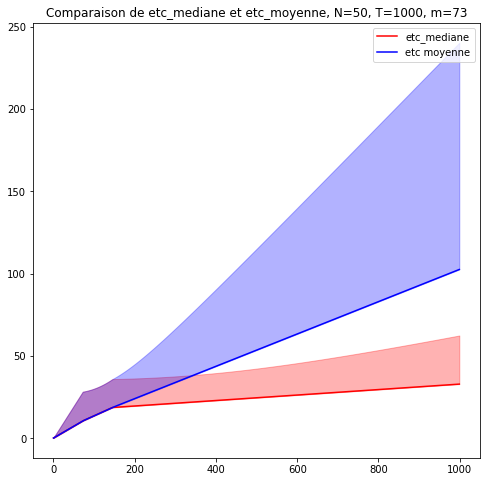

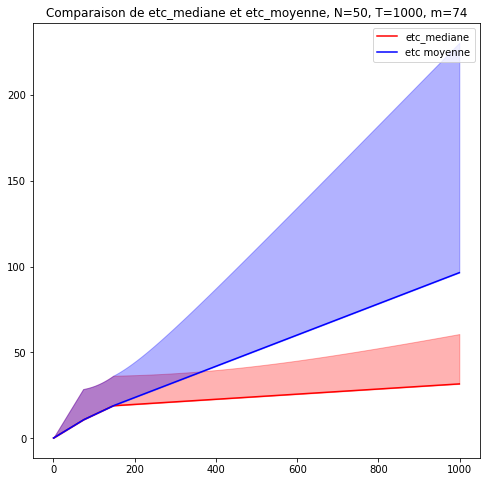

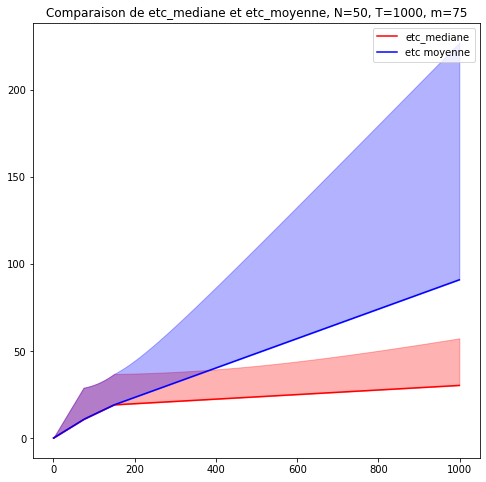

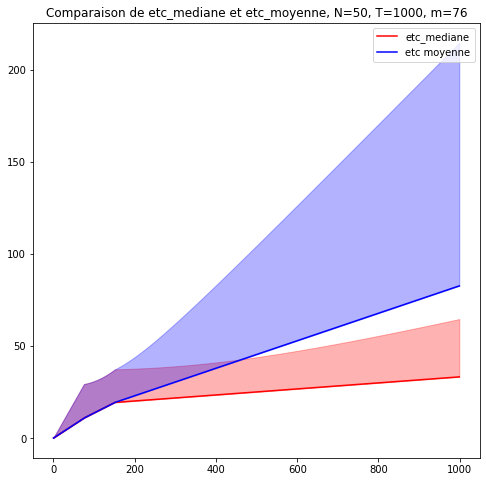

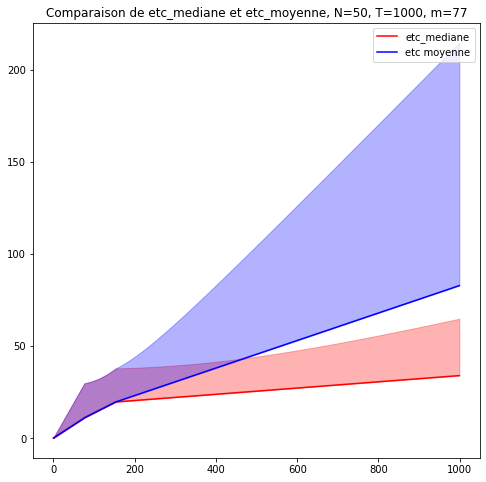

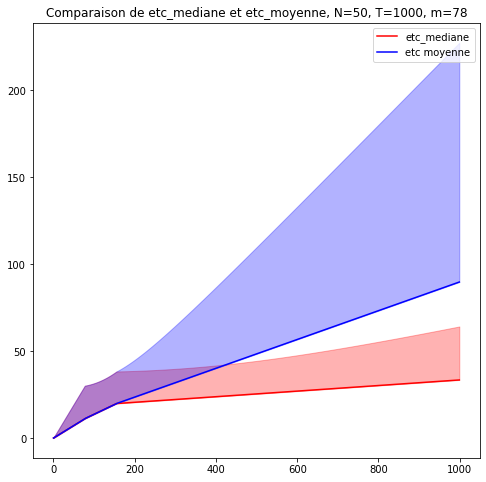

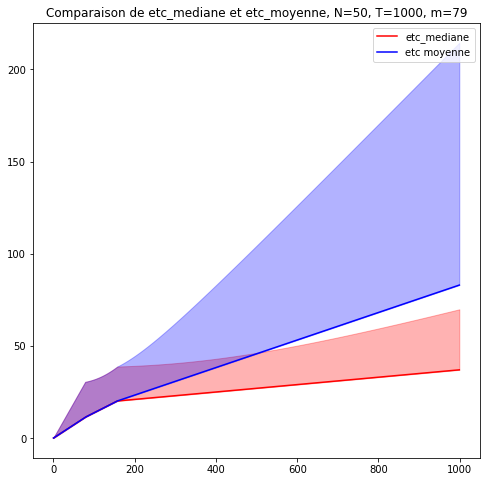

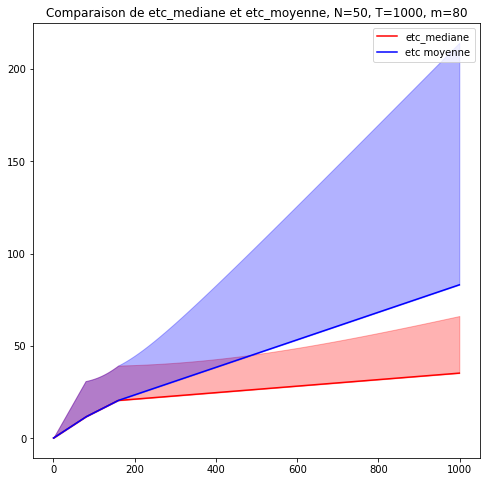

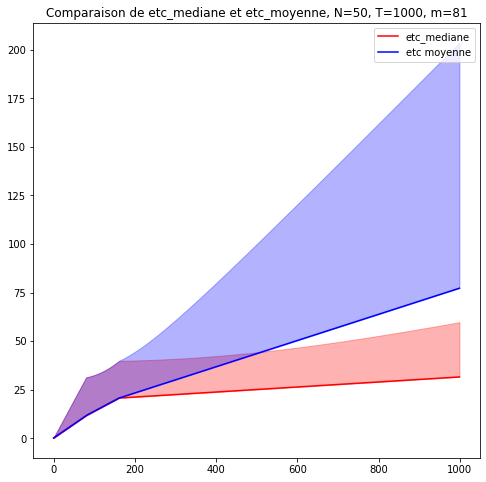

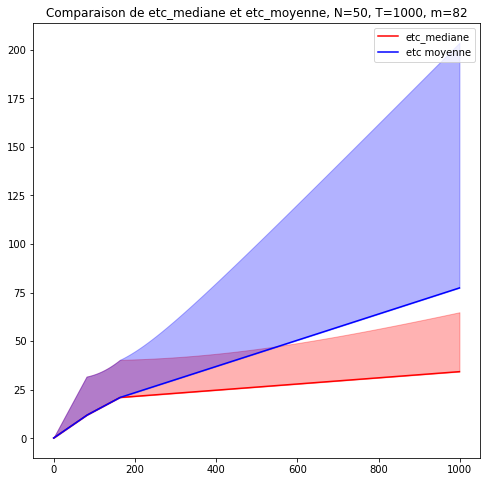

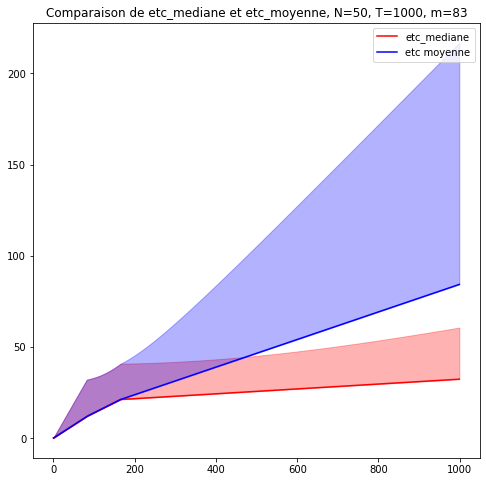

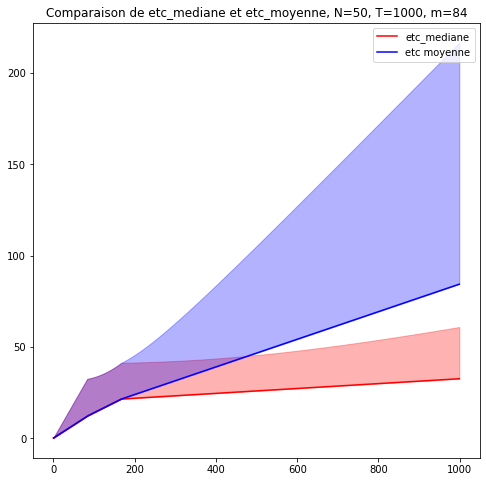

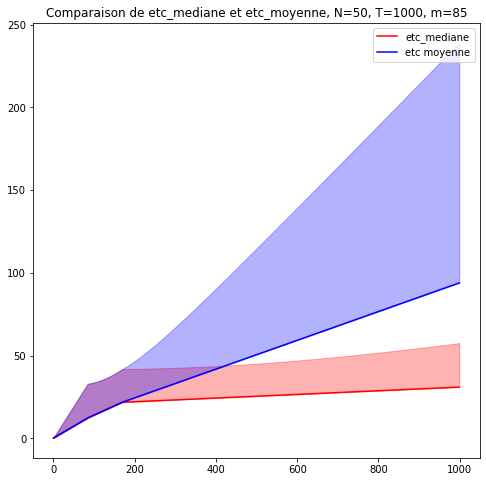

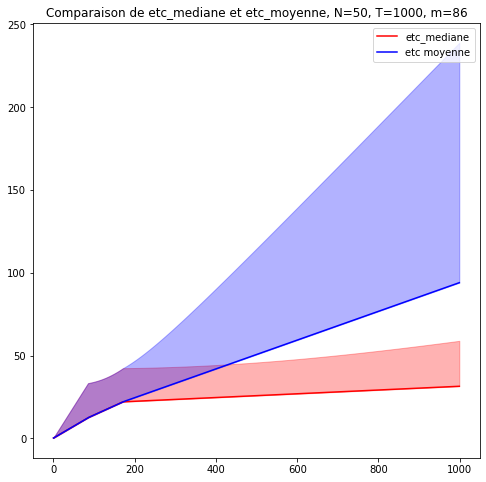

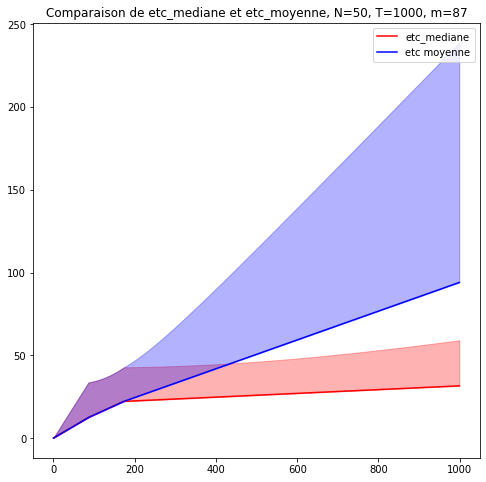

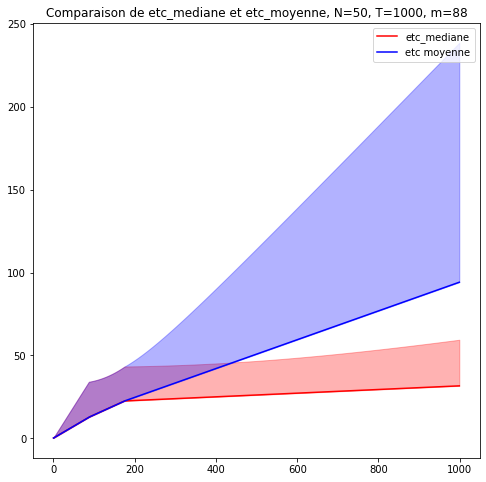

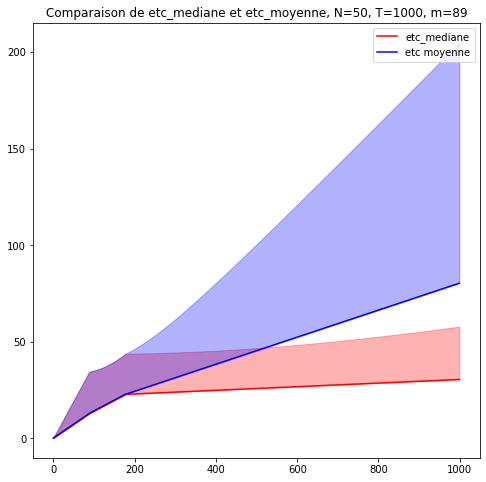

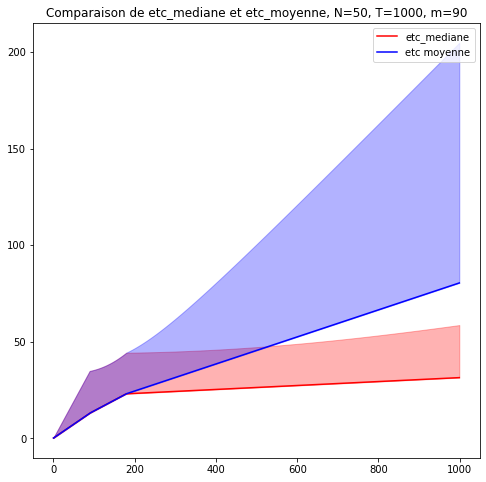

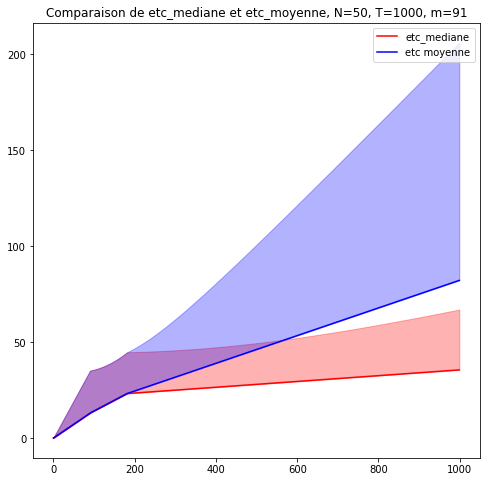

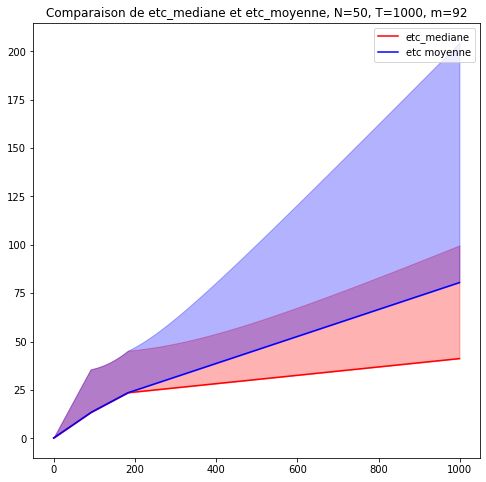

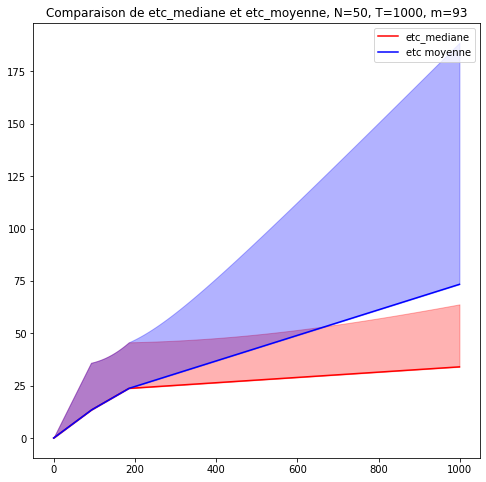

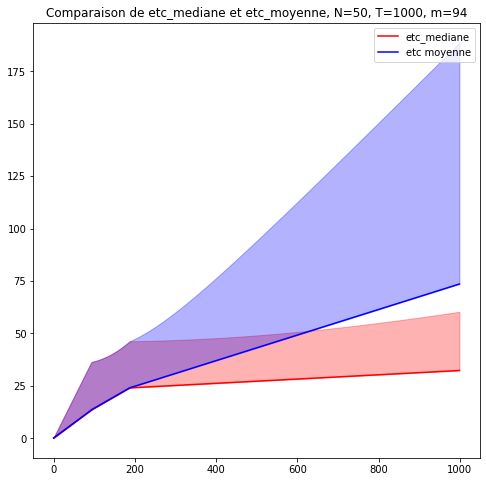

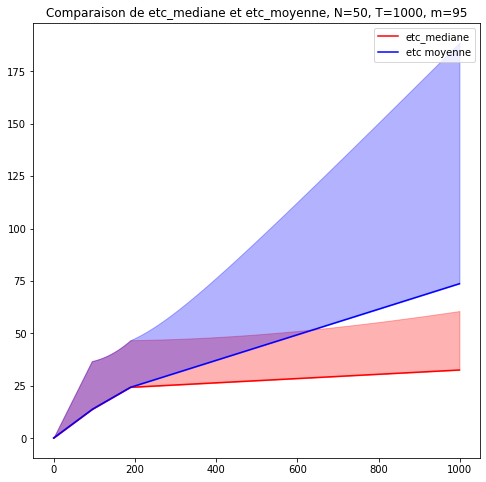

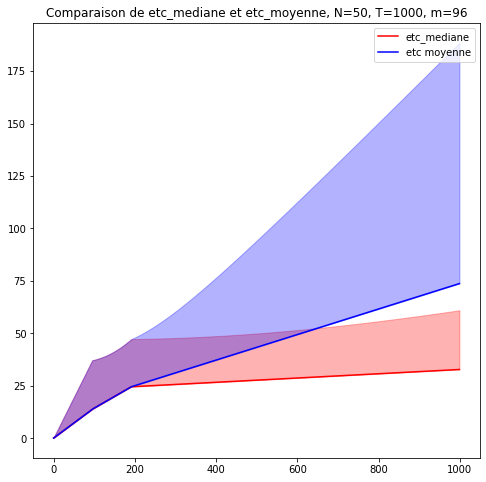

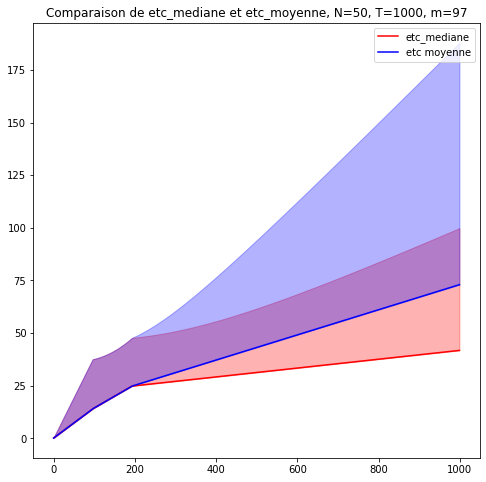

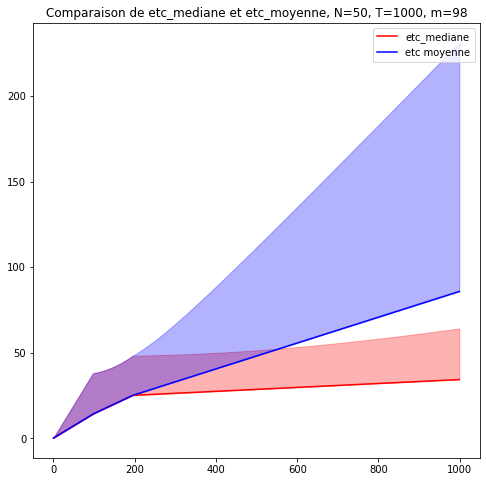

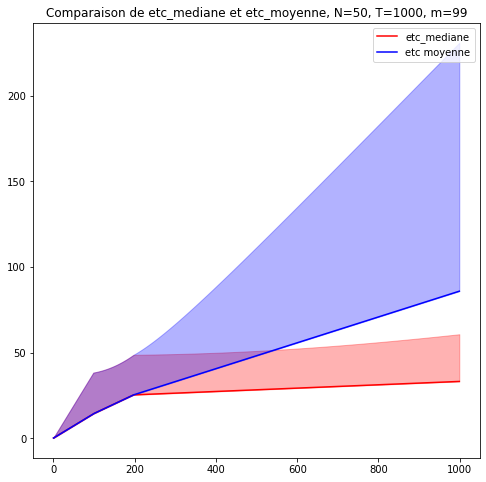

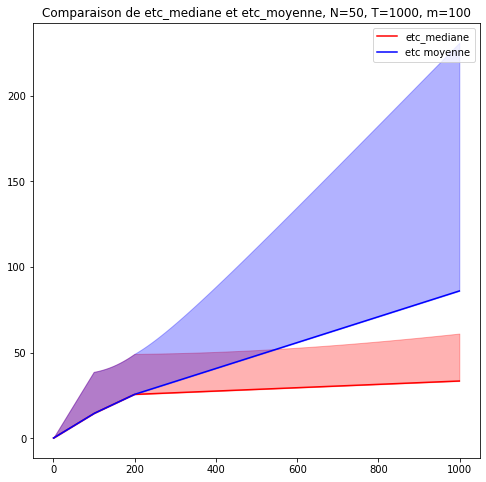

In [19]:
N,T = 50, 1000
loc=np.random.rand(50,2)
scale=np.array([1,1])

for m in range(1,101):

    cum_regrets_etc_median = []

    for i in range(N):
        banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
        etc(banditest, T=T, m=m, estimator=median_estimator, discret=False)
        cum_regrets_etc_median.append(banditest.get_cumulative_regret())

    cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
    cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

    plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label="etc_mediane") 
    plt.fill_between(range(T), cum_regrets_etc_median_moy, cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', alpha=0.3)

    cum_regrets_etc_moyenne = []

    for i in range(N):
        banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
        etc(banditest, T=T, m=m, estimator=mean_estimator, discret=False)
        cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
    cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
    cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

    plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue',label='etc moyenne') 
    plt.fill_between(range(T), cum_regrets_etc_moyenne_moy, cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', alpha=0.3)

    plt.title('Comparaison de etc_mediane et etc_moyenne, N={}, T={}, m={}'.format(N,T,m))
    plt.legend()
    plt.show()

#print(cum_regrets)
#print(cum_regrets_moy)
#print(cum_regrets_sd)

Ci-dessous, on définit epsilon_greedy avec l'option de median pour le calcul de l'estimateur.

In [11]:
def epsilon_greedy(bandit, epsilon, T, median=False):
    '''Play the given bandit over T rounds and return the greedy action . '''
    
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    r = np.zeros(T)        #Préparation du vecteur de rewards, init. 0
    
    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    
    estimateur = np.zeros(K) 
                                        
    #Le jeu commence
    for t in range(T):
        
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = np.random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = np.random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
    
        #Modifier la moyenne ou la médiane de l'action jouée
        if(median):
            estimateur[action_played]=np.median(R[action_played])
        else:
            estimateur[action_played]=np.mean(R[action_played])
            

Tests sur epsilon_greedy, comparaison des méthodes utilisées pour l'estimation

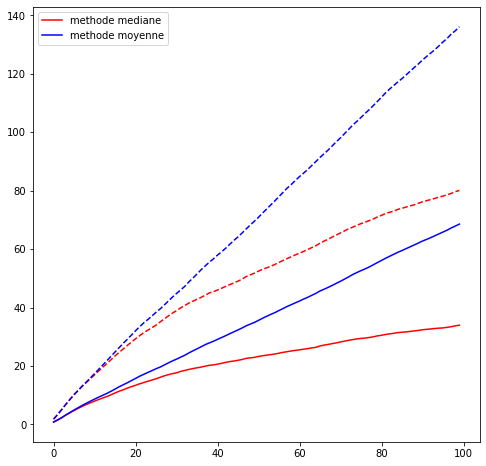

In [12]:
N,T = 50, 100

epsilon=0.1

loc=np.array([4,6])
scale=np.array([1,1])

cum_regrets_epsilon_greedy_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    epsilon_greedy(banditest, T=T, epsilon=epsilon, median=True)
    cum_regrets_epsilon_greedy_median.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_median)
cum_regrets_epsilon_greedy_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_median)

plt.plot(range(T),cum_regrets_epsilon_greedy_median_moy,color='red',label='methode mediane') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_median_moy + cum_regrets_epsilon_greedy_median_sd,color='red', linestyle='dashed')

cum_regrets_epsilon_greedy_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    epsilon_greedy(banditest, T=T, epsilon=epsilon, median=False)
    cum_regrets_epsilon_greedy_moyenne.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_moyenne)
cum_regrets_epsilon_greedy_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_moyenne)

plt.plot(range(T),cum_regrets_epsilon_greedy_moyenne_moy,color='blue',label='methode moyenne') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_moyenne_moy + cum_regrets_epsilon_greedy_moyenne_sd,color='blue', linestyle='dashed')

plt.legend()

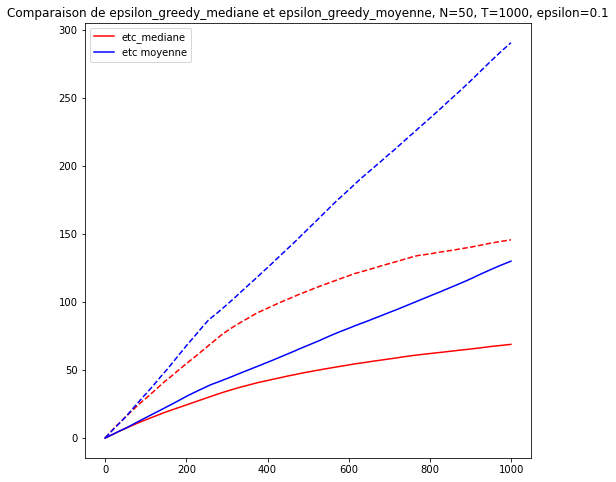

In [14]:
N,T = 50, 1000
epsilon=0.1

loc=np.random.rand(50,2)
scale=np.array([1,1])


cum_regrets_epsilon_greedy_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
    epsilon_greedy(banditest, T=T, epsilon=epsilon, median=True)
    cum_regrets_epsilon_greedy_median.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_median)
cum_regrets_epsilon_greedy_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_median)

plt.plot(range(T),cum_regrets_epsilon_greedy_median_moy,color='red',label="etc_mediane") 
plt.plot(range(T),cum_regrets_epsilon_greedy_median_moy + cum_regrets_epsilon_greedy_median_sd,color='red', linestyle='dashed')

cum_regrets_epsilon_greedy_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
    epsilon_greedy(banditest, T=T, epsilon=epsilon, median=False)
    cum_regrets_epsilon_greedy_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_epsilon_greedy_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_moyenne)
cum_regrets_epsilon_greedy_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_moyenne)

plt.plot(range(T),cum_regrets_epsilon_greedy_moyenne_moy, color='blue',label='etc moyenne') 
plt.plot(range(T),cum_regrets_epsilon_greedy_moyenne_moy + cum_regrets_epsilon_greedy_moyenne_sd, color='blue', linestyle='dashed')

plt.title('Comparaison de epsilon_greedy_mediane et epsilon_greedy_moyenne, N={}, T={}, epsilon={}'.format(N,T,epsilon))
plt.legend()
plt.show()

#print(cum_regrets)
#print(cum_regrets_moy)
#print(cum_regrets_sd)

Ci-dessous, on définit epsilon_greedy_rule (règle $\epsilon=1/\sqrt{t}$) avec l'option de median pour le calcul de l'estimateur.


In [15]:
# Algorithme Greedy-epsilon avec epsilon=1/sqrt(t)

def epsilon_greedy_rule(bandit, T, median=False):
    '''Play the given bandit over T rounds and return the greedy action . '''
    
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    r = np.zeros(T)        #Préparation du vecteur de rewards, init. 0
    
    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    estimateur = np.zeros(K)
    
    #Le jeu commence
    for t in range(T):
    
        epsilon = min([1,1/sqrt(t+1)]) #Ici, c'est t+1 car t commence à 0 dans Python.
            
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = np.random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = np.random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
    
        #Modifier la moyenne ou la médiane de l'action jouée
        if median:
            estimateur[action_played]=np.median(R[action_played])
        else:
            estimateur[action_played]=np.mean(R[action_played])

Tests sur epsilon_greedy_rule , comparaison des méthodes utilisées pour l'estimation


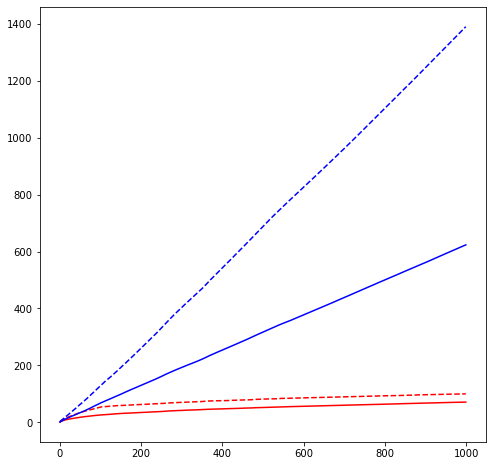

In [21]:
N,T = 50, 1000

loc=np.array([4,6])
scale=np.array([1,1])

cum_regrets_epsilon_greedy_rule_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    epsilon_greedy_rule(banditest, T=T, median=True)
    cum_regrets_epsilon_greedy_rule_median.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_rule_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_rule_median)
cum_regrets_epsilon_greedy_rule_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_rule_median)

plt.plot(range(T),cum_regrets_epsilon_greedy_rule_median_moy,color='red') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_rule_median_moy + cum_regrets_epsilon_greedy_rule_median_sd,color='red', linestyle='dashed')

cum_regrets_epsilon_greedy_rule_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc,scale=scale,seed=i)
    epsilon_greedy_rule(banditest, T=T, median=False)
    cum_regrets_epsilon_greedy_rule_moyenne.append(banditest.get_cumulative_regret())
 
cum_regrets_epsilon_greedy_rule_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_rule_moyenne)
cum_regrets_epsilon_greedy_rule_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_rule_moyenne)

plt.plot(range(T),cum_regrets_epsilon_greedy_rule_moyenne_moy,color='blue') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_rule_moyenne_moy + cum_regrets_epsilon_greedy_rule_moyenne_sd,color='blue', linestyle='dashed')



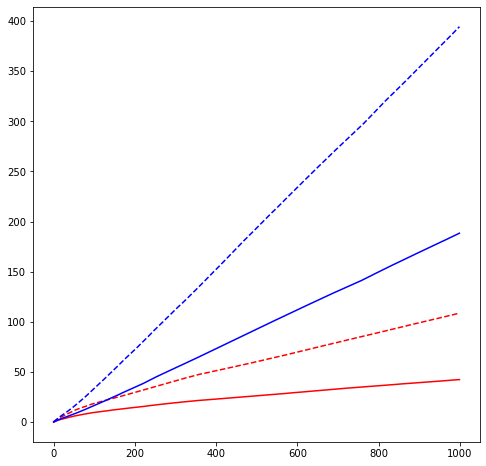

In [22]:
N,T = 50, 1000
epsilon=0.1

loc=np.random.rand(50,2)
scale=np.array([1,1])

cum_regrets_epsilon_greedy_rule_median = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
    epsilon_greedy_rule(banditest, T=T, median=True)
    cum_regrets_epsilon_greedy_rule_median.append(banditest.get_cumulative_regret())

cum_regrets_epsilon_greedy_rule_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_rule_median)
cum_regrets_epsilon_greedy_rule_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_rule_median)

plt.plot(range(T),cum_regrets_epsilon_greedy_rule_median_moy,color='red') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_rule_median_moy + cum_regrets_epsilon_greedy_rule_median_sd,color='red', linestyle='dashed')

cum_regrets_epsilon_greedy_rule_moyenne = []

for i in range(N):
    banditest = CauchyBandit(loc=loc[i],scale=scale,seed=i)
    epsilon_greedy_rule(banditest, T=T, median=False)
    cum_regrets_epsilon_greedy_rule_moyenne.append(banditest.get_cumulative_regret())
 
cum_regrets_epsilon_greedy_rule_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_epsilon_greedy_rule_moyenne)
cum_regrets_epsilon_greedy_rule_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_epsilon_greedy_rule_moyenne)

plt.plot(range(T),cum_regrets_epsilon_greedy_rule_moyenne_moy,color='blue') #affichage du graphique
plt.plot(range(T),cum_regrets_epsilon_greedy_rule_moyenne_moy + cum_regrets_epsilon_greedy_rule_moyenne_sd,color='blue', linestyle='dashed')


Explorations potentielles:

-Étendre les similuations ci-dessus à des estimateurs robustes autres que la médiane (comme la moyenne tronquée ou autre).
Au lieu, d'avoir un boléen pour déterminer la méthode de calcul de l'estimateur, ça pourrait être un string qui détermine la quelle méthode utilisée dans une liste de méthode.

-Étendre les simulations ci-dessus à des algorithmes plus complexes.

-Est-ce que cela nous démarque suffisemment de la littérature? Certains articles étudient l'utilisation des mesures statistiques plus robuste que la moyenne dans le cas de distribution avec premier moment fini (et deuxième) mais avec des distributions non-sigma-sousgaussienne.

-Tenter de définir le problème (mesure de performance) avec des distributions d'espérance non-définie et de formes non-symétriques, par exemple distribution de Pareto avec $k=1.$ 

-Tenter de trouver des applications.